In [ ]:

!pip install kaggle #installing the kaggle API
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

# Check if kaggle.json was found
if kaggle_api_key:
    filename = "/content/.kaggle/kaggle.json"
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
    fh = io.FileIO(filename, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print("Download %d%%." % int(status.progress() * 100))
    os.chmod(filename, 600)
    #copying the .json file to the required directory
    !mkdir ~/.kaggle
    !cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
else:
    print("Error: 'kaggle.json' not found in Google Drive. Please make sure it's uploaded.")

Error: 'kaggle.json' not found in Google Drive. Please make sure it's uploaded.


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.multiclass import OneVsRestClassifier # Import OneVsRestClassifier
from sklearn.dummy import DummyClassifier # Import DummyClassifier
from sklearn.metrics import hamming_loss

In [ ]:

!kaggle datasets download -d stackoverflow/stacksample -p ./data

Dataset URL: https://www.kaggle.com/datasets/stackoverflow/stacksample
License(s): other
100% 1.11G/1.11G [00:13<00:00, 101MB/s] 
100% 1.11G/1.11G [00:13<00:00, 88.3MB/s]


In [ ]:

!unzip ./data/stacksample.zip

Archive:  ./data/stacksample.zip
  inflating: Answers.csv             
  inflating: Questions.csv           
  inflating: Tags.csv                


In [ ]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tqdm import tqdm

In [ ]:
ques = pd.read_csv("Questions.csv",encoding="ISO-8859-1")
ques.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [ ]:
ques.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Id            1264216 non-null  int64  
 1   OwnerUserId   1249762 non-null  float64
 2   CreationDate  1264216 non-null  object 
 3   ClosedDate    55959 non-null    object 
 4   Score         1264216 non-null  int64  
 5   Title         1264216 non-null  object 
 6   Body          1264216 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


In [ ]:
tags = pd.read_csv("Tags.csv",encoding="ISO-8859-1")
tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [ ]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


In [ ]:
tags['Tag'] = tags['Tag'].astype(str)
grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))
grouped_tags.reset_index()

,Id,Tag
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
...,...,...
1264211,40143210,php .htaccess
1264212,40143300,google-bigquery
1264213,40143340,android android-studio
1264214,40143360,javascript vue.js


In [ ]:
grouped_tags.head(30)

,Tag
Id,
80,flex actionscript-3 air
90,svn tortoisesvn branch branching-and-merging
120,sql asp.net sitemap
180,algorithm language-agnostic colors color-space
260,c# .net scripting compiler-construction
330,c++ oop class nested-class
470,.net web-services
580,sql-server sql-server-2005 deployment release-...
650,c# visual-studio versioning


In [ ]:
ques.drop(columns = ['OwnerUserId','CreationDate','ClosedDate'],inplace = True)
ques = ques.merge(grouped_tags,on='Id')
ques.head()

,Id,Score,Title,Body,Tag
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [ ]:
ques = ques[ques['Score'] > 5]
ques.head()

,Id,Score,Title,Body,Tag
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [ ]:
del tags
del grouped_tags

In [ ]:
ques['Tag'] = ques['Tag'].apply(lambda x: x.split())
all_tags = [item for sublist in ques['Tag'].values for item in sublist]

In [ ]:
unique_tags = list(set(all_tags))

In [ ]:
len(unique_tags)

14883

In [ ]:
new_df = ques.drop(columns = ['Id','Score'])

In [ ]:
new_df

,Title,Body,Tag
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]"
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]"
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s..."
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net, scripting, compiler-construction]"
...,...,...,...
1262915,How to use a dict to subset a DataFrame?,"<p>Say, I have given a DataFrame with most of ...","[python, pandas, dataframe, categorical-data]"
1263065,Is there a way to use itertools in python to c...,<p>Let's say I have the following code:</p>\n\...,"[python, iterator, nested-loops, itertools]"
1263399,How can I force file ordering in F# projects u...,<p>I'm trying to work with vscode in my WebSha...,"[f#, vscode]"
1263454,Why does my result data returned as void* gets...,<p>I am working in a project with a huge legac...,[c++]


In [ ]:
flat_list = [item for sublist in new_df['Tag'].values for item in sublist]

keywords = nltk.FreqDist(flat_list)

keywords = nltk.FreqDist(keywords)

frequencies_words = keywords.most_common(100)
tags_features = [word[0] for word in frequencies_words]

In [ ]:
tags_features

['c#',
 'java',
 'javascript',
 'android',
 'python',
 'c++',
 'php',
 'jquery',
 '.net',
 'ios',
 'html',
 'css',
 'c',
 'iphone',
 'objective-c',
 'ruby-on-rails',
 'sql',
 'asp.net',
 'mysql',
 'ruby',
 'r',
 'git',
 'asp.net-mvc',
 'linux',
 'sql-server',
 'node.js',
 'angularjs',
 'django',
 'performance',
 'algorithm',
 'string',
 'xcode',
 'arrays',
 'wpf',
 'eclipse',
 'haskell',
 'windows',
 'scala',
 'multithreading',
 'json',
 'c++11',
 'regex',
 'visual-studio',
 'html5',
 'osx',
 'swift',
 'database',
 'unit-testing',
 'spring',
 'xml',
 'bash',
 'ajax',
 'delphi',
 'cocoa-touch',
 'ruby-on-rails-3',
 'visual-studio-2010',
 'linq',
 'debugging',
 'generics',
 'perl',
 'entity-framework',
 'mongodb',
 'winforms',
 'cocoa',
 'security',
 'postgresql',
 'css3',
 'templates',
 'twitter-bootstrap',
 'shell',
 'list',
 'google-chrome',
 'vim',
 'oop',
 'image',
 'hibernate',
 'gcc',
 'asp.net-mvc-3',
 'facebook',
 'oracle',
 'rest',
 'maven',
 'http',
 'exception',
 'tsql',
 'ma

In [ ]:
import matplotlib.pyplot as plt

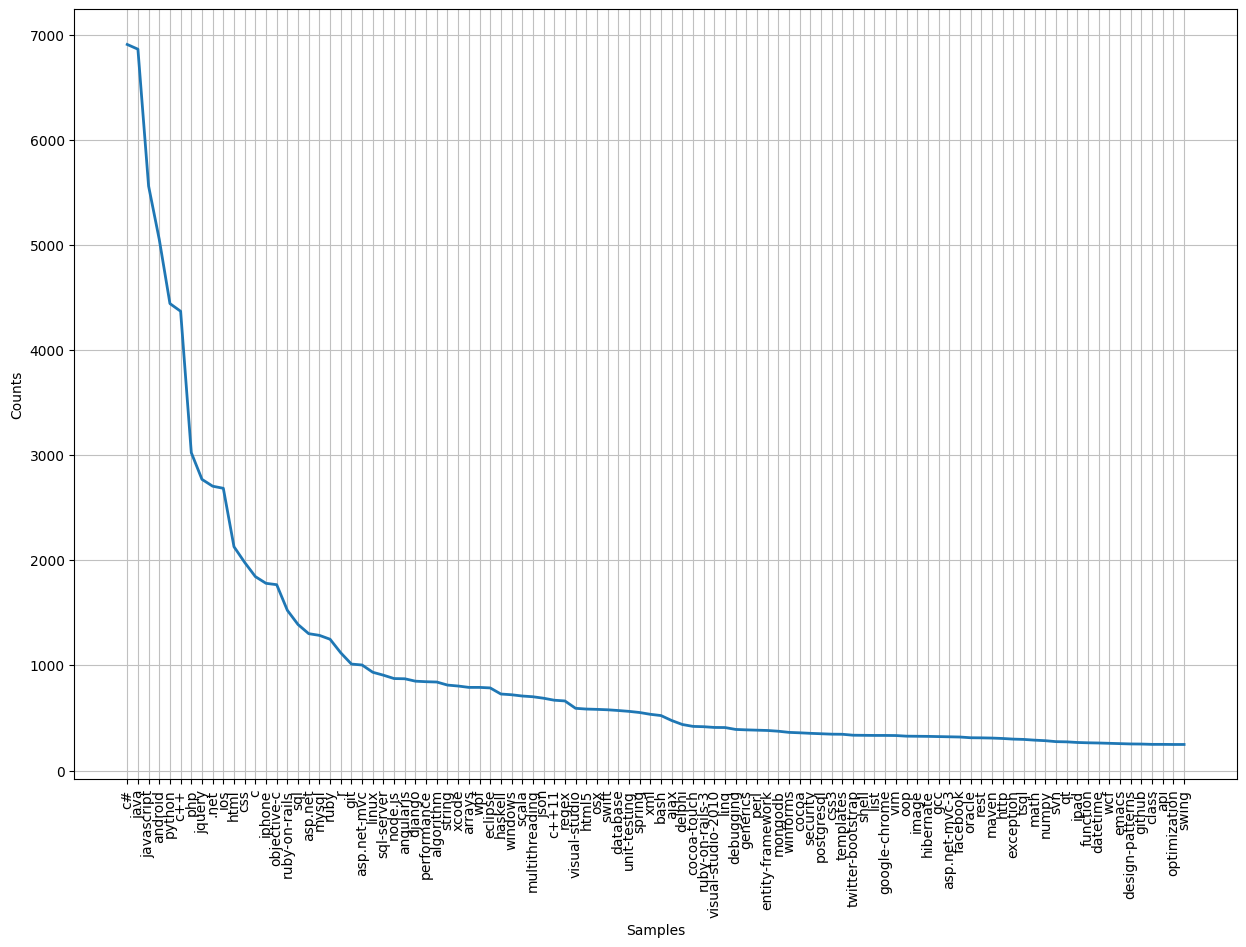

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
keywords.plot(100, cumulative=False)

In [ ]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

In [ ]:
new_df['Tag'] = new_df['Tag'].apply(lambda x: most_common(x))
new_df['Tag'] = new_df['Tag'].apply(lambda x: x if len(x)>0 else None)

In [ ]:
new_df.shape

(72950, 3)

In [ ]:
new_df.head()

,Title,Body,Tag
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,None
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,[svn]
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,[algorithm]
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net]"


In [ ]:
new_df.dropna(subset=['Tag'],inplace = True)

In [ ]:
new_df.head(50)

,Title,Body,Tag
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,[svn]
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,[algorithm]
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net]"
5,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,"[c++, oop, class]"
6,Homegrown consumption of web services,<p>I've been writing a few web services for a ...,[.net]
7,Deploying SQL Server Databases from Test to Live,<p>I wonder how you guys manage deployment of ...,[sql-server]
8,Automatically update version number,<p>I would like the version property of my app...,"[c#, visual-studio]"
9,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...,"[windows, visual-studio]"
10,How do I connect to a database and loop over a...,<p>What's the simplest way to connect and quer...,"[c#, database]"


In [ ]:
# Converting html to text in the body

new_df['Body'] = new_df['Body'].apply(lambda x: BeautifulSoup(x).get_text())

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [ ]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_text(x))

In [ ]:
token = ToktokTokenizer()

In [ ]:
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [ ]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

In [ ]:
def clean_punct(text):
    words=token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    for w in words:
        if w in tags_features:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))

    filtered_list = strip_list_noempty(punctuation_filtered)

    return ' '.join(map(str, filtered_list))

In [ ]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_punct(x))

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
lemma = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):

    stop_words = set(stopwords.words("english"))

    words=token.tokenize(text)

    filtered = [w for w in words if not w in stop_words]

    return ' '.join(map(str, filtered))

In [ ]:
new_df['Body'] = new_df['Body'].apply(lambda x: lemitizeWords(x))
new_df['Body'] = new_df['Body'].apply(lambda x: stopWordsRemove(x))

In [ ]:
new_df['Title'] = new_df['Title'].apply(lambda x: str(x))
new_df['Title'] = new_df['Title'].apply(lambda x: clean_text(x))
new_df['Title'] = new_df['Title'].apply(lambda x: clean_punct(x))
new_df['Title'] = new_df['Title'].apply(lambda x: lemitizeWords(x))
new_df['Title'] = new_df['Title'].apply(lambda x: stopWordsRemove(x))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer_train = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8',
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                       max_features=100)

In [ ]:
text = new_df['Body']

In [ ]:
TF_IDF_matrix = vectorizer_train.fit_transform(text)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

no_topics = 20
lda = LatentDirichletAllocation(
    n_components=no_topics,
    max_iter=5,
    learning_method='online',
    learning_offset=50,
    random_state=11
).fit(TF_IDF_matrix)

In [ ]:
#!pip install --upgrade scikit-learn

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("--------------------------------------------")
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("--------------------------------------------")


no_top_words = 10
display_topics(lda, vectorizer_train.get_feature_names_out(), no_top_words)

--------------------------------------------
Topic 0:
div function var html script class page jquery id input
--------------------------------------------
--------------------------------------------
Topic 1:
use app ios would find xcode like know android application
--------------------------------------------
--------------------------------------------
Topic 2:
00 scala font 09 01 02 tab utf-8 socket constant
--------------------------------------------
--------------------------------------------
Topic 3:
array list number data value would use like way function
--------------------------------------------
--------------------------------------------
Topic 4:
android width color height div background scroll style image top
--------------------------------------------
--------------------------------------------
Topic 5:
import python module modules def random filter statement docs 22
--------------------------------------------
--------------------------------------------
Topic 6:
b

In [ ]:
X1 = new_df['Body']
X2 = new_df['Title']
y = new_df['Tag']

In [ ]:
print(X1)

1          really good tutorials explain branch merge apa...
2          anyone get experience create sql-based asp.net...
3          something pseudo-solved many time never quite ...
4          little game write c use database back-end trad...
5          work collection class use video playback recor...
                                 ...                        
1262834    suppose pushback popfront methods stl list imp...
1262915    say give dataframe columns categorical data da...
1263065    let say follow code 123 b 246 c 357 j b k c pr...
1263454    work project huge legacy code base try re-desi...
1264205    take andrã ¡ kovã ¡ cs dbindexhs simple implem...
Name: Body, Length: 63167, dtype: object


In [ ]:

from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)

In [ ]:
vectorizer_X1 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8',
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

vectorizer_X2 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8',
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

In [ ]:
X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X2.fit_transform(X2)

In [ ]:
print(X1_tfidf)

  (0, 182)	0.3502804560359635
  (0, 828)	0.3306377649659706
  (0, 127)	0.3042721396551083
  (0, 563)	0.4415207450263649
  (0, 143)	0.43612179268889717
  (0, 350)	0.34646335438307085
  (0, 416)	0.3002125350648934
  (0, 718)	0.2830079981908186
  (1, 971)	0.16549938864054103
  (1, 870)	0.17804844933412622
  (1, 837)	0.19306996278833594
  (1, 958)	0.15837092880790468
  (1, 297)	0.2336092163264514
  (1, 633)	0.3059878782473618
  (1, 573)	0.20092068827587634
  (1, 808)	0.19723503946256854
  (1, 941)	0.1915823695407341
  (1, 967)	0.10167359419787564
  (1, 588)	0.2200912484943696
  (1, 223)	0.19082363410991343
  (1, 562)	0.2315217699620466
  (1, 693)	0.21172305222931728
  (1, 983)	0.09545769810921859
  (1, 370)	0.1150346015696878
  (1, 991)	0.19541749012895096
  :	:
  (63166, 829)	0.020146517998375316
  (63166, 584)	0.022966925177800513
  (63166, 162)	0.025859250935864362
  (63166, 889)	0.012365319625313238
  (63166, 541)	0.027422652182348024
  (63166, 616)	0.009815419548299611
  (63166, 497)	

In [ ]:
X1_tfidf.shape

(63167, 1000)

In [ ]:
!pip install scipy
from scipy.sparse import hstack

X_tfidf = hstack([X1_tfidf,X2_tfidf]) # Use hstack after importing it

In [ ]:
X_tfidf.shape

(63167, 2000)

In [ ]:
y_bin.shape

(63167, 100)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.2, random_state = 0) # Do 80/20 split

In [ ]:
y_train.shape


(50533, 100)

In [ ]:
X_train.shape

(50533, 2000)

In [ ]:
'''

from google.colab import files
import pandas as pd

X_train_dense = X_train.toarray()
#X_test_dense = X_test.toarray()
# y_train and y_test are already dense arrays, no conversion needed
#y_train_dense = y_train.toarray()
#y_test_dense = y_test.toarray()

X_train_df = pd.DataFrame(X_train_dense)
#X_test_df = pd.DataFrame(X_test_dense)
#y_train_df = pd.DataFrame(y_train) # Use y_train directly
#y_test_df = pd.DataFrame(y_test) # Use y_test directly


X_train_df.to_csv('X_train.csv',index = False)
#X_test_df.to_csv('X_test.csv',index = False)
#y_train_df.to_csv('y_train.csv',index = False)
#y_test_df.to_csv('y_test.csv',index = False)

files.download('X_train.csv')
#files.download('X_test.csv')
#files.download('y_train.csv')
#files.download('y_test.csv')

'''

"\n\nfrom google.colab import files\nimport pandas as pd\n\nX_train_dense = X_train.toarray()\n#X_test_dense = X_test.toarray()\n# y_train and y_test are already dense arrays, no conversion needed\n#y_train_dense = y_train.toarray()\n#y_test_dense = y_test.toarray()\n\nX_train_df = pd.DataFrame(X_train_dense)\n#X_test_df = pd.DataFrame(X_test_dense)\n#y_train_df = pd.DataFrame(y_train) # Use y_train directly\n#y_test_df = pd.DataFrame(y_test) # Use y_test directly\n\n\nX_train_df.to_csv('X_train.csv',index = False)\n#X_test_df.to_csv('X_test.csv',index = False)\n#y_train_df.to_csv('y_train.csv',index = False)\n#y_test_df.to_csv('y_test.csv',index = False)\n\nfiles.download('X_train.csv')\n#files.download('X_test.csv')\n#files.download('y_train.csv')\n#files.download('y_test.csv')\n\n"

In [ ]:
def avg_jacard(y_true,y_pred):

    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)

    return jacard.mean()*100

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Jacard score: {}".format(avg_jacard(y_test, y_pred)))
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))
    print("---")

In [ ]:
# Import necessary modules
'''
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.multiclass import OneVsRestClassifier # Import OneVsRestClassifier
from sklearn.dummy import DummyClassifier # Import DummyClassifier
from sklearn.metrics import hamming_loss
'''

#sgd = SGDClassifier()
#lr = LogisticRegression()
#mn = MultinomialNB()
svc = LinearSVC()
#perceptron = Perceptron()
#pac = PassiveAggressiveClassifier()
#dummy = DummyClassifier() # Assuming you want to use a dummy classifier as well
'''
for classifier in [svc]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print_score(y_pred, classifier)'''

clf = OneVsRestClassifier(svc)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print_score(y_pred, clf)

#After running all the algorithms SVC is found out to be best

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
'''

mlpc = MLPClassifier()
mlpc.fit(X_train, y_train)

y_pred = mlpc.predict(X_test)

print_score(y_pred, mlpc)

'''

'\n\nmlpc = MLPClassifier()\nmlpc.fit(X_train, y_train)\n\ny_pred = mlpc.predict(X_test)\n\nprint_score(y_pred, mlpc)\n\n'

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
'''

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print_score(y_pred, rfc)

'''

'\n\nrfc = RandomForestClassifier()\nrfc.fit(X_train, y_train)\n\ny_pred = rfc.predict(X_test)\n\nprint_score(y_pred, rfc)\n\n'

In [ ]:
param_grid = {'estimator__C':[1,10,50]
              }

In [ ]:
from sklearn import model_selection
from sklearn.metrics import make_scorer

In [ ]:
svc = OneVsRestClassifier(LinearSVC())
CV_svc = model_selection.GridSearchCV(estimator=svc, param_grid=param_grid, cv= 5, verbose=10, scoring=make_scorer(avg_jacard,greater_is_better=True))
CV_svc.fit(X_train, y_train)

In [ ]:
print(CV_svc.best_params_)

{'estimator__C': 1}


In [ ]:
best_model = CV_svc.best_estimator_

In [ ]:
y_pred = best_model.predict(X_test)
print_score(y_pred, best_model)

Clf:  OneVsRestClassifier
Jacard score: 52.356208115666725
Hamming loss: 0.9552794047807505
---


In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
import pickle

In [ ]:
pickle.dump(best_model, open('model.pkl', 'wb'))

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
tl = 0
tr = 0
bl = 0
br = 0


for i in range(y_train.shape[1]):

    #print(multilabel_binarizer.classes_[i])
    cm = confusion_matrix(y_test[:,i], y_pred[:,i])
    #print(cm[0][0])
    if i == 820:
      continue

    tl += cm[0][0]
    tr += cm[0][1]
    bl += cm[1][0]
    br += cm[1][1]

    print(i)
    print(cm)




0
[[12033    54]
 [  447   100]]
1
[[12526    15]
 [   55    38]]
2
[[12445    21]
 [   87    81]]
3
[[11528    40]
 [  194   872]]
4
[[12443     7]
 [   49   135]]
5
[[12567    14]
 [   45     8]]
6
[[12405    55]
 [  103    71]]
7
[[12346    30]
 [  166    92]]
8
[[12402    41]
 [   99    92]]
9
[[12566    11]
 [   44    13]]
10
[[12520     7]
 [   46    61]]
11
[[12220    58]
 [  203   153]]
12
[[11060   175]
 [  618   781]]
13
[[11674    91]
 [  260   609]]
14
[[12453    31]
 [  103    47]]
15
[[12574    12]
 [   45     3]]
16
[[12553     4]
 [   69     8]]
17
[[12530    10]
 [   90     4]]
18
[[12186    74]
 [  123   251]]
19
[[12561    13]
 [   45    15]]
20
[[12503    29]
 [   84    18]]
21
[[12571    17]
 [   36    10]]
22
[[12523    27]
 [   50    34]]
23
[[12542     2]
 [   39    51]]
24
[[12573    11]
 [   36    14]]
25
[[12465     7]
 [   31   131]]
26
[[12472     9]
 [   55    98]]
27
[[12591     1]
 [   16    26]]
28
[[12547    20]
 [   36    31]]
29
[[12551    17]
 [   4

In [ ]:
print(tl,tr,bl,br)

1240916 2627 9442 10415


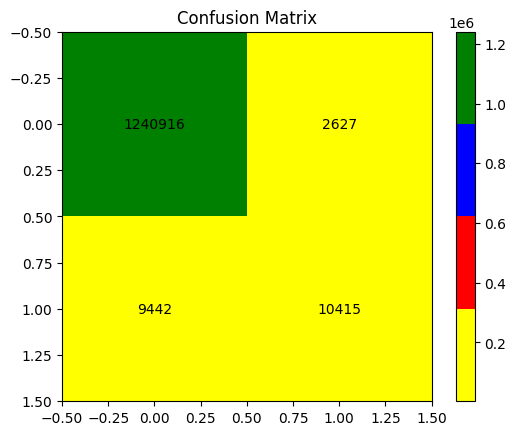

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Define the 2x2 matrix
matrix = np.array([[tl, tr], [bl, br]])

# Define a custom colormap
colors = ['yellow', 'red', 'blue', 'green']
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=4)

# Plot the matrix with the custom colormap
plt.imshow(matrix, cmap=cmap, interpolation='none')

# Annotate each cell with the numeric value
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        plt.text(j, i, matrix[i, j], ha='center', va='center', color='black')

# Show color scale and plot title
plt.colorbar()
plt.title('Confusion Matrix')
plt.show()
